# An Introduction to Fairness in Machine Learning

Imagine yourself in this scenario: You have just accepted a job at a banking company, and are tasked with the creation of a supervised learning predictor to aid in loan approval/denial. The bank has recently been under ridicule for unintentionally discriminating against certain minority groups in their loan approval process, so they want you to do some investigation for them. You are given data from the <a href='https://www.federalreserve.gov/boarddocs/rptcongress/creditscore/' target='blank'>Report to the Congress on Credit Scoring and Its Effects on the Availability and Affordability of Credit</a> in 2007 to guide your research. They want you to look at distributions of TranksRisk credit scores from 2007 in order to determine how they can fix thir process for approving and/or denying loans to people.

In order to become a quick fairness expert, they take you through a quick crash-course, where you learn the following :

***

## Fairness Crash Course

### I. What is a fairness model?

Fairness models seek to fix machine learning predictors for discrimination. Specifically, they allow data scientists to algorithmically and statistically measure how *fair* a predictor is by providing requirements to ensure *fairness*. Ususally this involves identifying minority groups within a training population distribution to ensure that predictor outcomes aren't unintentionally benefitting majority groups over minority ones. Using a fairness model's requirements, we can also determine if a predictor is *unfair* (or discriminatory).

### II. Equal Opportunity Model

This fairness model will be the easiest to utilize for your research, because the requirements for ensuring fairness directly use performance metrics easily quantified in a binary predictor. The Equal Opportunity Model takes into account three important details :

1. All groups (minority and majority) are defined by a protected attribute. 
    - ** Denoted as 'A' **
    - For your research, you will choose demographic groups as your A values
2. The advantaged outcome group. 
    - ** Denoted as 'Y = 1' **
    - For this scenario, an advantaged outcome group is the group of people who deserve a loan approval. We will discuss this at greater length in Part 3 of the tutorial.
3. The binary predictor (getting granted a loan or not).
    - ** Denoted as '$\hat Y$ = 1' for a loan approval **
    - ** Denoted as '$\hat Y$ = 0' for loan denial **

A Predictor is said to satisfy fairness under Equal Opportunity iff the probability of getting a positive prediction is the same for all advantaged outcome members in a protected group. <br/><br/>
$$ P(\hat Y = 1 | A = a, Y = 1) \text{ is equal for ALL protected groups a.} $$

*Translation: The probability that someone gets approved a loan given that they deserved a loan, is the same for all protected groups (minority and majority).*

***

## Task #1 : Determine if the old method *was* discriminating against minorities

Based on the crash course above, you have your work cut out now. Your manager tells you that she would like you to create a predictor that does the following:

1. Takes in an individuals credit score (TransRisk Score) and demographic information.
2. Spits out whether they were approved or denied a loan.

She tells you that the bank's previous method of determining if someone was approved or denied simply took into account their TransRisk credit score. Anyone who had a equal to or above 23.5 was automatically approved. Anyone who had a score below 23.5 was automatically denied. The score 23.5 was their singular **Threshold Score** of choice. You decide to begin your research by understanding how this process worked.

### I. The Old Way:

*** For a threshold score x, someone is given a loan if they have a TransRisk score >= x. Using the data from the Federal Reserve Report, plot the dataframe that shows ***
1. A vertical line through the old threshold TransRisk score, 23.5
2. The probability of an individual receiving a loan based on their race: $ P\text{(score} \geq x \text{ | race)} $

*Hint:* Looking at the Report, you come across <a href='https://www.federalreserve.gov/boarddocs/rptcongress/creditscore/figtables3.htm#d3A' target='blank'>Figure 3A</a>. This indicates: $ P\text{(score} \leq x \text{ | race)}$. Seems like a great starting point.

In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ProbScoreLeqXGivenRace = pd.read_csv('Figure3A.csv').set_index('Score') / 100

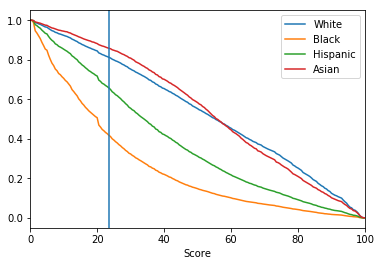

In [20]:
ProbScoreEqXGivenRace = ProbScoreLeqXGivenRace.diff().fillna(value=ProbScoreLeqXGivenRace.loc[0])
ProbScoreGeqXGivenRace = ProbScoreEqXGivenRace.iloc[::-1].cumsum()[::-1]

ProbScoreGeqXGivenRace.plot()
plt.axvline(23.5)

Now that you've visualized how the old system worked, you start by testing if this old method was actually discriminatory or not. Remembering the *fairness* requirements from the **Equal Opportunity Model** you know that you want $ P(\hat Y = 1 | A = a, Y = 1) \text{ to be equal for ALL protected groups a.} $

You translate this to mean that you want $ \text{P(Score} \geq x \text{ | Deserved a Loan Approval, race) to be equal for ALL races} $

### II. Figure Out if Old Way Was Discriminatory

Someone *Deserves a Loan Approval* if they have historically not defaulted on their loans. Fortunately, the Federal Reserve Report gives us some great data to help us out!

*Hint:* Looking at the Report, you come across <a href='https://www.federalreserve.gov/boarddocs/rptcongress/creditscore/figtables7.htm#d7A' target='blank'>Figure 7A</a>. This indicates: $ P\text{(score} \leq x \text{ | Individual was historically NonDefaulting, race)}$. Seems like a great starting point.

*** Task: Plot the following: ***
1. The $ P\text{(score} \geq x \text{ | NonDefault, race)}$ for each race
2. A vertical line at the old threshold score, 23.5

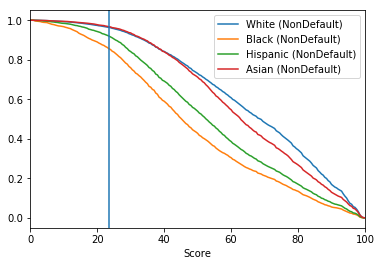

In [21]:
ProbScoreLeqXGivenDefaultingAndRace = pd.read_csv("Figure7A.csv").set_index("Score") / 100
ProbScoreEqXGivenDefaultingAndRace = (ProbScoreLeqXGivenDefaultingAndRace
                                      .diff().fillna(value=ProbScoreLeqXGivenDefaultingAndRace.loc[0]))
ProbScoreEqXGivenNDAndRace = ProbScoreEqXGivenDefaultingAndRace[['White (NonDefault)', 
                                              'Black (NonDefault)',
                                             'Hispanic (NonDefault)',
                                             'Asian (NonDefault)']]
ProbScoreGeqXGivenNDAndRace = ProbScoreEqXGivenNDAndRace.iloc[::-1].cumsum()[::-1]
ProbScoreGeqXGivenNDAndRace.plot()
plt.axvline(23.5)

Is the $ P\text{(score} \geq x \text{ | NonDefault, race)}$ the same for each race at the old threshold value of 23.5? 

** SPOILER: **
It isn't! The bank *wasn't* being fair according to the **Equal Opportunity Model**. Now, it's time to go fix their mess.

***

## Task #2 : Create a *Fair* Predictor for Loan Approvals

Now you know that choosing one threshold value as a cutoff for loan approval will **not** satisfy the Equal Opportunity Model's requirements for *fairness*. Instead, you'll have to choose a different threshold score for each race. The question now is... which thresholds should we choose?

### I. Utilizing Sensitivity
In the last section, you plotted $ P(\hat Y = 1 | A = a, Y = 1) $, this is also known as the **sensitivity** value. For the Equal Opportunity Model, you need the **sensitivity** to be the same for all races. Why don't you start by restructuring the data frame you created before?

** Task : **
1. Make the index the sensitivity values and the columns the TransRisk score values.
2. Plot the new dataframe. y values = Sensitivity, x values = Scores per race.
3. Plot a vertical line at an arbitrary sensitivity value (because we need sensitivity to be the same for all races).

In [5]:
sensitivities = ProbScoreGeqXGivenNDAndRace.round(2)
sensitivities.columns = ['white', 'black', 'hispanic', 'asian']

In [6]:
# creating a dataframe with all possible rounded sensitivity values to be the index
totalsDF = pd.DataFrame({
    'sensitivity': np.arange(0.0, 1.01, 0.01).tolist()
})

In [7]:
# function to format the threshold scores to match the sensitivity value at the index
def getScoreArray(race, data):
    scores = [None] * 101
    for index, row in data.iterrows():
        sens = data.loc[index][race]
        if(len(totalsDF[totalsDF['sensitivity'] == sens].index.values) >= 1):
            i = totalsDF[totalsDF['sensitivity'] == sens].index.values[0]
            scores[i] = index
    return scores

In [8]:
for demographic in ['asian', 'black', 'hispanic', 'white']:
    totalsDF['t_' + demographic]  = getScoreArray(demographic, sensitivities[[demographic]])

In [9]:
totalsDF.set_index('sensitivity').head()

,t_asian,t_black,t_hispanic,t_white
sensitivity,,,,
0.00,100.0,100.0,100.0,100.0
0.01,99.0,98.0,98.5,99.0
0.02,NaN,97.5,97.5,NaN
0.03,98.0,95.0,96.5,98.0
0.04,97.5,94.0,95.0,97.5


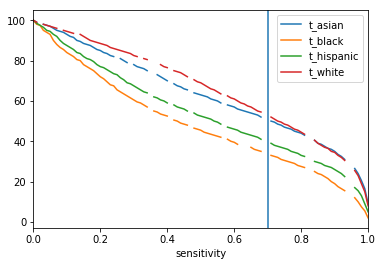

In [10]:
totalsDF.set_index('sensitivity').plot()
#arbitrary sensitivity value to visualize what a singular sensitivity value looks like
plt.axvline(0.7)

Now you can visualize what choosing a singular sensitivity value would look like: four different threshold scores, one score for each race.

Your next question : ** what singular sensitivity value should you choose? **

### II. Utilizing Loss to Get The Precision Value 
In order to determine what singular senstivity value you want to choose, you'll need to do some other calculations first. For supervised learning predictors, one way to detect errors is to calculate the difference between the actual output and the predictor's output. One function used to compute the error of a predictor is called a **Loss Function**. The bank you work for calculates loss using False Positives (FP) and False Negatives (FN), and every loss value can be associated with a precision value. You are told that precision is inversely proportional to the loss that the bank is willing to accept. In order to determine what the old loss that the bank was willing to accept was, you'll need to calculate the precision for each demographic at each score, average those values to calculate a 'total precision' at each score, and then see what precision value is located at the old threshold score of 23.5. This precision value will be used in the next section.

$ \text{Precision   ==   P(Y} = 1 | \hat Y = 1 \text{ , race})$

$ \text{Precision   ==   P(NonDefault | Score } \geq x \text{ , race)} $

** Your Tasks : **
1. Calculate the precision for each race at each TransRisk score
2. Plot this dataframe to visualize your findings. y values indicate precision, x values indicate the TransRisk score for each race.
3. Calculate a 'total precision' value for each TransRisk score by taking the mean of the demographic precisions.
4. Find what 'total precision' value is at a threshold score of 23.5, let's call this P.
5. 1 - P = the loss that the bank was willing to take on, let's call this L.

*Hints:*
- Looking at the Report, you come across <a href='https://www.federalreserve.gov/boarddocs/rptcongress/creditscore/figtables6.htm#d6A' target='blank'>Figure 6A</a>. This indicates: $ P\text{(NonDefault | Score} = x\text{ , race). Should be helpful..}$

- $ \text{P(NonDefault | Score } \geq x \text{ , race)} $

    $ <==> \frac{ \text{P(NonDefault and Score} \geq x \text{ , race)}}{ \text{P(Score} \geq x \text{ , race)}} $

    $ <==>  \frac{ \sum_{x^1 \geq x} \text{P(Score} = x^1 \text{ , race)} * \text {P(NonDefault | Score} = x^1 \text{ , race)}}{\sum_{x^1 \geq x} \text{P(Score} = x \text{ , race)}} $

    $ \text{where } x \text{ is a threshold score and } x^1 \text{is an individual's score} $
    


In [11]:
# Task 1: Calculate the precision for each race at each TransRisk score
score_cdf = pd.read_csv("Figure3A.csv", index_col="Score") / 100.
nondefault_given_score = 1 - pd.read_csv("Figure6A.csv", index_col="Score") / 100.
score_cdf_given_nondefault = pd.read_csv("Figure7A.csv", index_col="Score") / 100.

In [12]:
score_pmf = score_cdf.diff().fillna(value=score_cdf.loc[0.0])
score_pmf_given_nondefault = score_cdf.diff().fillna(value=score_cdf_given_nondefault.loc[0.0])

In [13]:
precisions = (
    (score_pmf * nondefault_given_score).iloc[::-1].cumsum() /
    (score_pmf.iloc[::-1].cumsum())
)

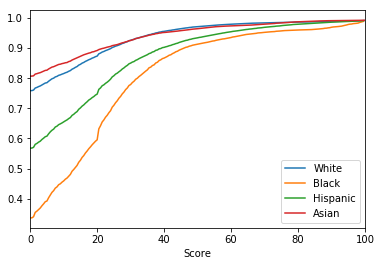

In [14]:
# Task 2: Plot this dataframe to visualize your findings.
# y values indicate precision, x values indicate the TransRisk score for each race.
precisions.iloc[::-1].plot()

In [15]:
# Task 3: Creating Total Precision Values

In [16]:
precisions = precisions.iloc[::-1]
precisions.head()

,White,Black,Hispanic,Asian
Score,,,,
0.0,0.758674,0.336551,0.568113,0.806850
0.5,0.758748,0.336784,0.568169,0.806850
1.0,0.760599,0.340514,0.570725,0.807828
1.5,0.767284,0.354880,0.580569,0.813501
2.0,0.769297,0.359006,0.583533,0.814946


In [22]:
precisions['total'] = precisions.mean(axis=1)
precisions.head()

,White,Black,Hispanic,Asian,total
Score,,,,,
0.0,0.758674,0.336551,0.568113,0.806850,0.617547
0.5,0.758748,0.336784,0.568169,0.806850,0.617638
1.0,0.760599,0.340514,0.570725,0.807828,0.619917
1.5,0.767284,0.354880,0.580569,0.813501,0.629059
2.0,0.769297,0.359006,0.583533,0.814946,0.631696


In [19]:
# proof of concept for meeting with Prof. Sun, will delete later
closestPrecision = min(precisions["total"], key=lambda x:abs(x-0.82))
precisions[precisions['total'] == closestPrecision]

,White,Black,Hispanic,Asian,total
Score,,,,,
23.5,0.895793,0.685374,0.791329,0.904249,0.819186


In [26]:
#Task #4: Find the total precision value at TransRisk Score 23.5
precisions.loc[[23.5]]

,White,Black,Hispanic,Asian,total
Score,,,,,
23.5,0.895793,0.685374,0.791329,0.904249,0.819186


In [33]:
#Task #4: Identify the P and L Values

*** P = 0.82, which means L == 1 - P == 0.18 ***

### III. Utilizing The New Precision Value
You have now discovered that your bank is striving for a maximum loss of L, which correlates to a precision of P. Now, we will reindex the precision data so we can merge our sensitivity dataset from section I. with this new precision dataset. First, delete the 'total precision' column you created in the previous section. You'll need to recalculate that here, since the sensitivity values are the new index.


** Your Tasks : **

1. Merge the new precision information with your dataframe from section I. (with the sensitivity values as the index). Now your old dataframe will have the sensitivity values as the index, the columns will include:
    - the threshold scores for each race at that sensitivity
    - the precision values for each race at that sensitivity
2. Take the mean of all of the precision values at each sensitivity to calculate a TotalPrecision at each TransRisk score (create a new column called TotalPrecision that will have a value for each sensitivity value). This is the same process as the last section, however now we calculate a total precision for each sensitivity (since we want the sensitivity to be the same for all the demographics).

In [30]:
import math

In [27]:
precisions = precisions[['White', 'Black', 'Hispanic', 'Asian']]
precisions.head()

,White,Black,Hispanic,Asian
Score,,,,
0.0,0.758674,0.336551,0.568113,0.806850
0.5,0.758748,0.336784,0.568169,0.806850
1.0,0.760599,0.340514,0.570725,0.807828
1.5,0.767284,0.354880,0.580569,0.813501
2.0,0.769297,0.359006,0.583533,0.814946


In [28]:
# Helper function to order the precisions for each race in association with the demographic specific threshold value at
# each index. This is for task #1.
def getPrecisionOrder(t_race, dataPrecision, race):
    prec = []
    for index, row in totalsDF.iterrows():
        if math.isnan(totalsDF[t_race][index]):
            currPrec = 0
        else:
            tmp = totalsDF[t_race][index]
            currPrec = dataPrecision.loc[tmp][race]
        prec.append(currPrec)
    return prec

In [31]:
# Task #1
for demographic in ['Asian', 'Black', 'Hispanic', 'White']:
    totalsDF[demographic.lower()[0] + '_prec'] = getPrecisionOrder('t_' + demographic.lower(), precisions, demographic)
    
totalsDF.set_index('sensitivity', inplace=True)
totalsDF.head()

,t_asian,t_black,t_hispanic,t_white,a_prec,b_prec,h_prec,w_prec
sensitivity,,,,,,,,
0.00,100.0,100.0,100.0,100.0,0.992100,NaN,NaN,0.991000
0.01,99.0,98.0,98.5,99.0,0.991872,0.982851,0.989912,0.990563
0.02,NaN,97.5,97.5,NaN,0.000000,0.981951,0.989207,0.000000
0.03,98.0,95.0,96.5,98.0,0.991684,0.978117,0.988933,0.990097
0.04,97.5,94.0,95.0,97.5,0.991604,0.975264,0.988056,0.989956


In [34]:
# Task #2 : Find the mean for all of the precision values at each sensitivity 
# to calculate a TotalPrecision at each TransRisk score

totalsDF['total_prec'] = totalsDF[['w_prec', 'b_prec', 'a_prec', 'h_prec']].mean(axis=1)
totalsDF.head()

,t_asian,t_black,t_hispanic,t_white,a_prec,b_prec,h_prec,w_prec,total_prec
sensitivity,,,,,,,,,
0.00,100.0,100.0,100.0,100.0,0.992100,NaN,NaN,0.991000,0.991550
0.01,99.0,98.0,98.5,99.0,0.991872,0.982851,0.989912,0.990563,0.988800
0.02,NaN,97.5,97.5,NaN,0.000000,0.981951,0.989207,0.000000,0.492790
0.03,98.0,95.0,96.5,98.0,0.991684,0.978117,0.988933,0.990097,0.987208
0.04,97.5,94.0,95.0,97.5,0.991604,0.975264,0.988056,0.989956,0.986220


***

## Task #3 : Find the Final Threshold Values for a *Fair* Predictor

Now you've done all of your research. You discovered that in order to comply to the Equal Opportunity Model's requirements for fairness, you'll need four separate threshold values and one shared sensitivity value. You discovered in section II. that the sensitivity value will be the one associated with a total precision as close as possible to P. Now, all you need to do is find which sensitivity value is the index for a total precision closest to P in the new dataframe you just created. The four threshold values at that sensitivity will be your final threshold values.

** Task : Determine final four threshold values to comply to Equal Opportunity Fairness Model. **

In [36]:
closestPrecision = min(totalsDF["total_prec"], key=lambda x:abs(x-0.82))
totalsDF[totalsDF['total_prec'] == closestPrecision]

,t_asian,t_black,t_hispanic,t_white,a_prec,b_prec,h_prec,w_prec,total_prec
sensitivity,,,,,,,,,
0.9,35.0,19.0,26.0,34.5,0.940778,0.584767,0.816581,0.940439,0.820641


*The final four threshold values indicate that an individual within a demographic group will be approved a loan if their TransRisk score is equal to or above their threshold, and will be denied if it falls below.*

***

# Results & Conclusions

** *Congratulations!* **

You have successfully taken your bank's discriminatory predictor and utilized a machine learning fairness model to make it into a 'fair' predictor! 
- Through visualizing the current system compared to the requirements of a fairness model, you discovered that the bank's current system was technically *unfair*.
- The Equal Opportunity Model provided a clear requirement to ensure fairness. As you learned later, this meant that the sensitivity of the predictor had to be the same for all races. Since one threshold value resulted in four different sensitivities, you were able to determine that discrimination will occur if you don't choose one threshold per demographic.
- Using loss minimization, you were able to use precision to find the single sensitivity that provided the least amount of loss.
- Finally, you discovered four new threshold values to be used; one for each demographic. Ensuring fairness and fixing a discriminatory predictor.
- Your bank is now happy **and** you are upholding ethical data science!
<br/><br/>

<center>
* What other commonly found predictors do you think might be inherently discriminatory?*
</center>


Inspired by <a href='https://arxiv.org/pdf/1610.02413.pdf' target='blank'>Equality of Opportunity in Supervised Learning</a> by Hardt et. all